In [ ]:
!pip install tensorflow==2.0

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0


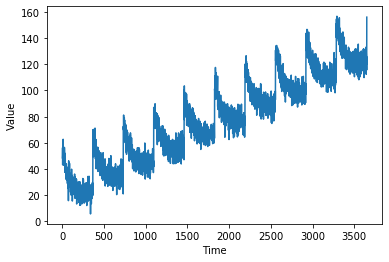

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 2 * np.pi),
                    1/ np.exp(3* season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.15)  
baseline = 10
amplitude = 40
slope = 0.03
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

Desired output -- a chart that looks like this:

![Chart showing upward trend and seasonailty](http://www.laurencemoroney.com/wp-content/uploads/2019/07/plot1.png)

In [4]:
series[:10]

array([48.547485, 50.58471 , 56.29027 , 43.232224, 50.524876, 49.761974,
       48.185684, 44.477154, 48.10621 , 62.73291 ], dtype=float32)

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [14]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

for window_dataset in dataset:
    for val in window_dataset:
      print(val.numpy(), end=" ")
      print()

TypeError: ignored

In [5]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

#change momentum improves accuracy
#adam didn't work as well
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.8)) 
model.fit(dataset,epochs=100,verbose=0)

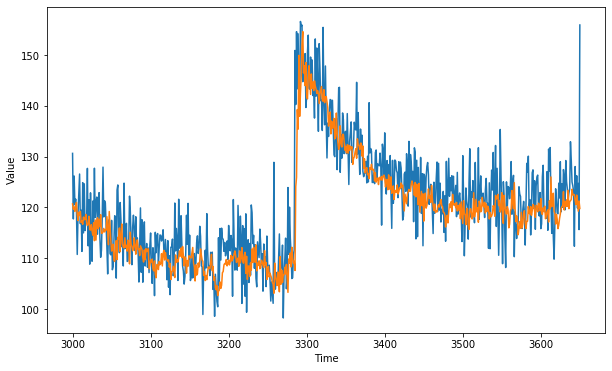

In [6]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [7]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
# EXPECTED OUTPUT
# A Value less than 3

4.774798

### Use Learning Rate Scheduler to Find the Optimal LR

In [8]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20)
)

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.8))
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

In [13]:
1e-8

1e-08

In [ ]:
for i in np.arange(100)/20:
    print(1e-8*10 ** i)

[1e-08, 0.001, 0, 300]

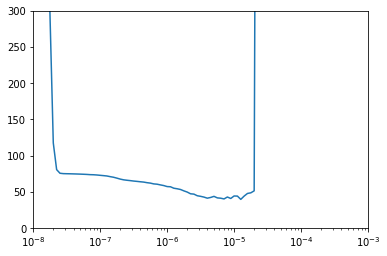

In [15]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [18]:
import pandas as pd
history_df=pd.DataFrame()
history_df['lr']=lrs
history_df['loss']=history.history['loss']

In [21]:
history_df.head(10)

,lr,loss
0,1.000000e-08,4134.828140
1,1.122018e-08,3358.012065
2,1.258925e-08,2503.809007
3,1.412538e-08,1613.083485
4,1.584893e-08,806.372530
5,1.778279e-08,296.619280
6,1.995262e-08,117.362521
7,2.238721e-08,80.522824
8,2.511886e-08,75.530157
9,2.818383e-08,75.016196


In [29]:
history_df['loss'].min()
print(history_df[history_df.loss == history_df.loss.min()]) 

          lr       loss
62  0.000013  39.500996


### Retrained with Optimal LR

In [31]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

#change momentum improves accuracy
#adam didn't work as well
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=0.000013, momentum=0.8)) 
history = model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500
94/94 [==============================] - 1s 13ms/step - loss: 107.5520
Epoch 2/500
94/94 [==============================] - 1s 7ms/step - loss: 55.6655
Epoch 3/500
94/94 [==============================] - 1s 7ms/step - loss: 51.7243
Epoch 4/500
94/94 [==============================] - 1s 8ms/step - loss: 43.1770
Epoch 5/500
94/94 [==============================] - 1s 7ms/step - loss: 47.6100
Epoch 6/500
94/94 [==============================] - 1s 7ms/step - loss: 47.0871
Epoch 7/500
94/94 [==============================] - 1s 7ms/step - loss: 49.0826
Epoch 8/500
94/94 [==============================] - 1s 7ms/step - loss: 48.8055
Epoch 9/500
94/94 [==============================] - 1s 7ms/step - loss: 41.5588
Epoch 10/500
94/94 [==============================] - 1s 7ms/step - loss: 46.8945
Epoch 11/500
94/94 [==============================] - 1s 7ms/step - loss: 41.1959
Epoch 12/500
94/94 [==============================] - 1s 6ms/step - loss: 47.9831
Epoch 13/500
94/94 [===

94/94 [==============================] - 1s 7ms/step - loss: 39.7922
Epoch 101/500
94/94 [==============================] - 1s 9ms/step - loss: 44.5074
Epoch 102/500
94/94 [==============================] - 1s 9ms/step - loss: 39.5591
Epoch 103/500
94/94 [==============================] - 1s 7ms/step - loss: 48.2712
Epoch 104/500
94/94 [==============================] - 1s 8ms/step - loss: 39.2072
Epoch 105/500
94/94 [==============================] - 1s 9ms/step - loss: 42.6305
Epoch 106/500
94/94 [==============================] - 1s 7ms/step - loss: 38.1566
Epoch 107/500
94/94 [==============================] - 1s 6ms/step - loss: 43.2914
Epoch 108/500
94/94 [==============================] - 1s 7ms/step - loss: 38.2693
Epoch 109/500
94/94 [==============================] - 1s 7ms/step - loss: 40.4514
Epoch 110/500
94/94 [==============================] - 1s 7ms/step - loss: 37.9039
Epoch 111/500
94/94 [==============================] - 1s 7ms/step - loss: 40.4198
Epoch 112/500
94/9

94/94 [==============================] - 1s 7ms/step - loss: 37.6070
Epoch 199/500
94/94 [==============================] - 1s 7ms/step - loss: 41.2595
Epoch 200/500
94/94 [==============================] - 1s 7ms/step - loss: 39.7881
Epoch 201/500
94/94 [==============================] - 1s 6ms/step - loss: 36.0214
Epoch 202/500
94/94 [==============================] - 1s 7ms/step - loss: 38.2778
Epoch 203/500
94/94 [==============================] - 1s 7ms/step - loss: 38.9400
Epoch 204/500
94/94 [==============================] - 1s 7ms/step - loss: 40.2212
Epoch 205/500
94/94 [==============================] - 1s 7ms/step - loss: 40.9793
Epoch 206/500
94/94 [==============================] - 1s 7ms/step - loss: 37.9381
Epoch 207/500
94/94 [==============================] - 1s 7ms/step - loss: 35.4627
Epoch 208/500
94/94 [==============================] - 1s 7ms/step - loss: 38.1959
Epoch 209/500
94/94 [==============================] - 1s 7ms/step - loss: 41.0157
Epoch 210/500
94/9

94/94 [==============================] - 1s 6ms/step - loss: 40.5311
Epoch 297/500
94/94 [==============================] - 1s 6ms/step - loss: 37.9133
Epoch 298/500
94/94 [==============================] - 1s 6ms/step - loss: 37.4664
Epoch 299/500
94/94 [==============================] - 1s 6ms/step - loss: 38.4730
Epoch 300/500
94/94 [==============================] - 1s 6ms/step - loss: 38.0636
Epoch 301/500
94/94 [==============================] - 1s 6ms/step - loss: 40.7760
Epoch 302/500
94/94 [==============================] - 1s 6ms/step - loss: 36.4865
Epoch 303/500
94/94 [==============================] - 1s 6ms/step - loss: 36.5010
Epoch 304/500
94/94 [==============================] - 1s 6ms/step - loss: 37.1456
Epoch 305/500
94/94 [==============================] - 1s 6ms/step - loss: 37.0112
Epoch 306/500
94/94 [==============================] - 1s 6ms/step - loss: 38.6291
Epoch 307/500
94/94 [==============================] - 1s 6ms/step - loss: 42.1974
Epoch 308/500
94/9

94/94 [==============================] - 1s 6ms/step - loss: 37.1625
Epoch 395/500
94/94 [==============================] - 1s 6ms/step - loss: 43.3623
Epoch 396/500
94/94 [==============================] - 1s 6ms/step - loss: 37.6765
Epoch 397/500
94/94 [==============================] - 1s 7ms/step - loss: 38.9669
Epoch 398/500
94/94 [==============================] - 1s 6ms/step - loss: 37.5481
Epoch 399/500
94/94 [==============================] - 1s 6ms/step - loss: 38.6542
Epoch 400/500
94/94 [==============================] - 1s 6ms/step - loss: 37.2342
Epoch 401/500
94/94 [==============================] - 1s 6ms/step - loss: 39.7432
Epoch 402/500
94/94 [==============================] - 1s 6ms/step - loss: 38.5624
Epoch 403/500
94/94 [==============================] - 1s 6ms/step - loss: 42.2632
Epoch 404/500
94/94 [==============================] - 1s 7ms/step - loss: 36.9214
Epoch 405/500
94/94 [==============================] - 1s 6ms/step - loss: 37.7024
Epoch 406/500
94/9

94/94 [==============================] - 1s 7ms/step - loss: 38.1467
Epoch 493/500
94/94 [==============================] - 1s 7ms/step - loss: 36.1262
Epoch 494/500
94/94 [==============================] - 1s 7ms/step - loss: 39.2384
Epoch 495/500
94/94 [==============================] - 1s 6ms/step - loss: 39.1273
Epoch 496/500
94/94 [==============================] - 1s 7ms/step - loss: 36.9795
Epoch 497/500
94/94 [==============================] - 1s 7ms/step - loss: 39.0685
Epoch 498/500
94/94 [==============================] - 1s 7ms/step - loss: 35.4467
Epoch 499/500
94/94 [==============================] - 1s 7ms/step - loss: 37.4079
Epoch 500/500
94/94 [==============================] - 1s 6ms/step - loss: 37.3758


In [ ]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

In [ ]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
# print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

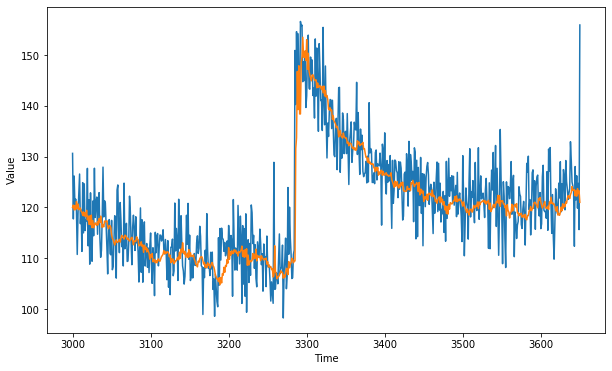

In [32]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [33]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.456174